**IMPORTING REQUIRED LIBRARIES**

In [28]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import pathlib
from pathlib import Path
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils  import to_categorical
from keras.preprocessing.image import ImageDataGenerator


In [68]:
data_dir="/kaggle/input/corn-leaf-disease/corn"
root_dir='/kaggle/working/'

In [69]:
def countfiles(root_dir):
    for path in pathlib.Path(root_dir).iterdir():
        if path.is_dir():
             print( str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files inside the " + \
            str(path.name),'class')
countfiles(data_dir)

1000 files inside the Corn___Northern_Leaf_Blight class
1162 files inside the Corn___healthy class
1000 files inside the Corn___Cercospora_leaf_spot Gray_leaf_spot class
1192 files inside the Corn___Common_rust class


**DATASET PREPARATION**

In [80]:
def data_categories(d_path):
    categories=[]    #listdir-->used to get the list of all files and directories in the specified directory
    for folder_name in os.listdir(d_path):  #os.path.isdir()--->used to check whether the specified path is an existing directory or not.
        if os.path.isdir(os.path.join(d_path,folder_name)):
            no_of_files = len(glob.glob(os.path.join(d_path, folder_name)+"/*.JPG")) + len(glob.glob(os.path.join(d_path, folder_name)+"/*.jpg"))
            categories.append(np.array([folder_name,no_of_files]))
    categories.sort(key=lambda a:a[0])
    cat=np.array(categories)
    return list(cat[:, 0]),list(cat[:,1])
categories,no_of_files = data_categories("/kaggle/input/corn-leaf-disease/corn")
print(categories)

['Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy']


In [81]:
print("number of categories: ", len(categories))

number of categories:  4


In [82]:
df = pd.DataFrame({"category": categories, "number of files": no_of_files})
df

,category,number of files
0,Corn___Cercospora_leaf_spot Gray_leaf_spot,1000
1,Corn___Common_rust,1192
2,Corn___Northern_Leaf_Blight,1000
3,Corn___healthy,1162


In [83]:
def dataset(data_path, categories, width, height):
    x = []
    y = []
    for category_idx, category in enumerate(categories):
        path = os.path.join(data_path, category)
        count = 0
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            img_size = cv2.resize(img_array, (width, height))
            x.append(img_size)
            y.append(category_idx)
            count += 1
        print(f"Number of images in class {category_idx}: {count}")
    y = np.array(y)
    x = np.array(x).reshape(y.shape[0], width, height, 3)
    return x, y

x, y = dataset(data_path=data_dir, categories=['Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy'], width=100,height=100)


Number of images in class 0: 1000
Number of images in class 1: 1192
Number of images in class 2: 1000
Number of images in class 3: 1162


In [84]:
print(f'x shape:{x.shape}')
print(f"y shape: {y.shape}")

x shape:(4354, 100, 100, 3)
y shape: (4354,)


**IMAGES FROM CLASSES**

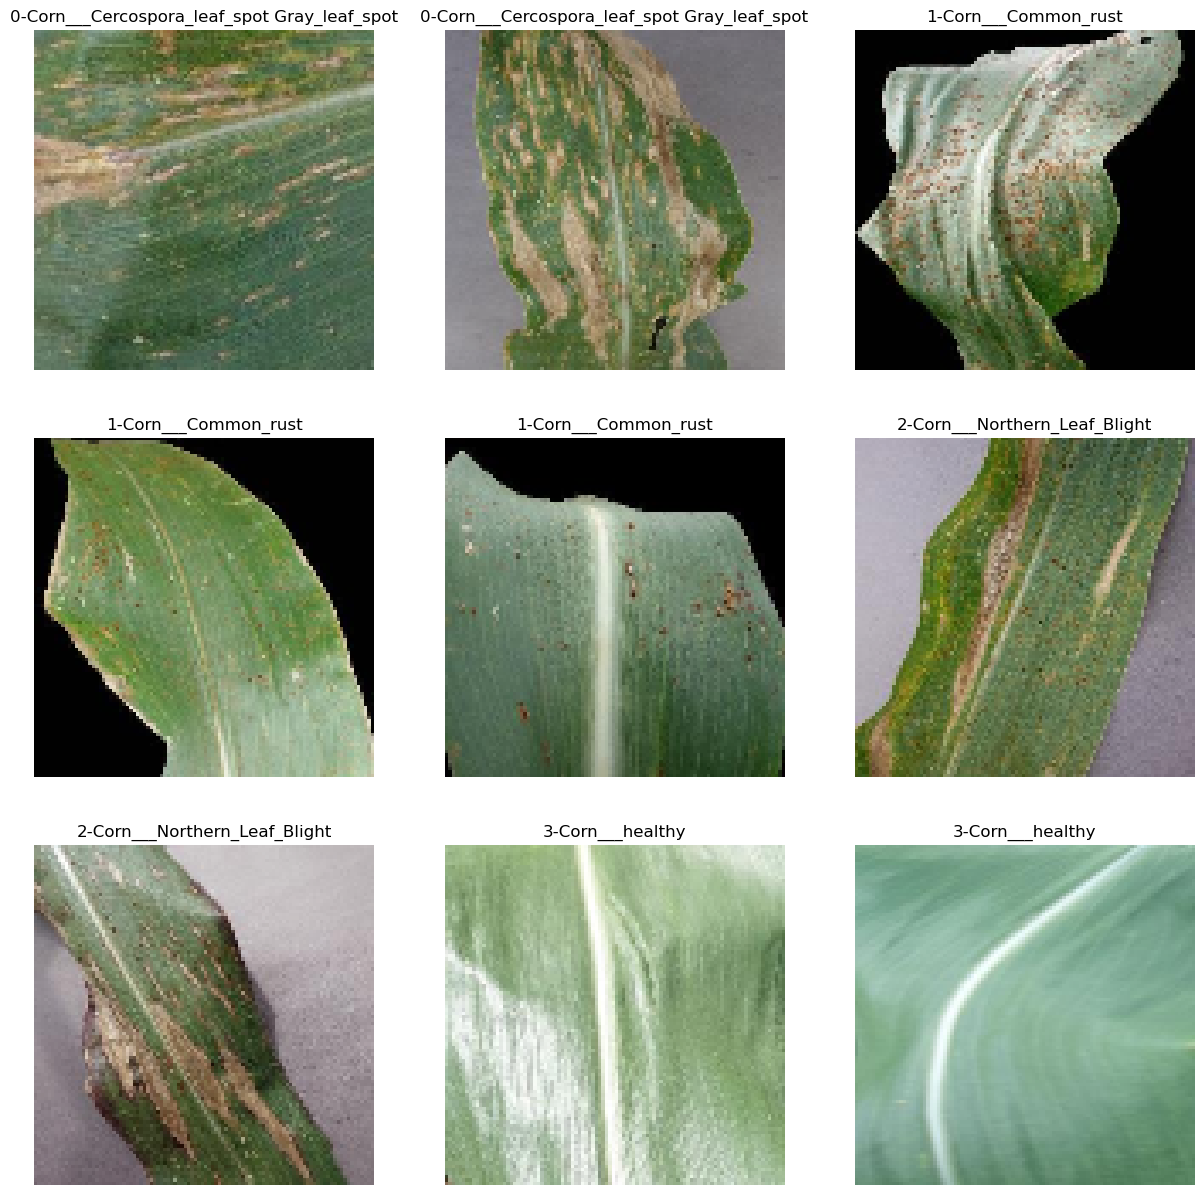

In [93]:
plt.figure(figsize=(15, 15))
st, end = 0,500
for i in range(9):
    plt.subplot(3, 3, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    plt.rcParams.update({'font.size':10})
    plt.imshow(x[idx][:, :, ::-1])
    plt.title(f"{y[idx]}-{categories[y[idx]]}")
    plt.axis("off")
plt.show()

**DATASET SPLITTING FOR TRAIN/VAL/TEST SETS**

In [94]:
y=np.reshape(y,(len(y),1))
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (3918, 100, 100, 3)
y_train: (3918, 1)
x_test: (436, 100, 100, 3)
y_test: (436, 1)


In [95]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,train_size=0.70)
x_test=x_test

print(f"x_train:{x_train.shape},y_train:{y_train.shape}")       
print(f"x_val: {x_val.shape},y_val:{y_val.shape}")        #70-20-10
print(f"x_test:{x_test.shape},y_test:{y_test.shape}")

x_train:(2742, 100, 100, 3),y_train:(2742, 1)
x_val: (1176, 100, 100, 3),y_val:(1176, 1)
x_test:(436, 100, 100, 3),y_test:(436, 1)


In [96]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_val:{x_val.shape},  y_val:{y_val.shape}")
print(f"x_test:{x_test.shape},  y_test:{y_test.shape}")

x_train:(2742, 100, 100, 3),  y_train:(2742, 4)
x_val:(1176, 100, 100, 3),  y_val:(1176, 4)
x_test:(436, 100, 100, 3),  y_test:(436, 4)


**DATA PREPROCESSING**

In [97]:
train_generator=ImageDataGenerator(rescale=1./255,
                                   rotation_range=2,
                                  horizontal_flip=True,
                                   shear_range=0.5,
                                  zoom_range=0.7)
val_generator=ImageDataGenerator(rescale=1./255,
                                 rotation_range=2,
                                 horizontal_flip=True,
                                 shear_range=0.5,
                                 zoom_range=0.1)
test_generator=ImageDataGenerator(rotation_range=2,
                                 horizontal_flip=True,
                                 zoom_range=0.1)

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

**MODEL BUILDING-CNN**

In [169]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense,MaxPooling2D,Dropout

In [301]:
model = keras.Sequential([
    # Convolutional layers 
                   #kernels,  #filters ,  #activation function,          #input
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    #tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    #tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D((2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),#0.2#0.5
    tf.keras.layers.Dense(4, activation='softmax')])


In [302]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_252 (Conv2D)         (None, 98, 98, 32)        896       
                                                                 
 conv2d_253 (Conv2D)         (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_116 (MaxPooli  (None, 48, 48, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_64 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_254 (Conv2D)         (None, 46, 46, 64)        18496     
                                                                 
 conv2d_255 (Conv2D)         (None, 44, 44, 64)        36928     
                                                     

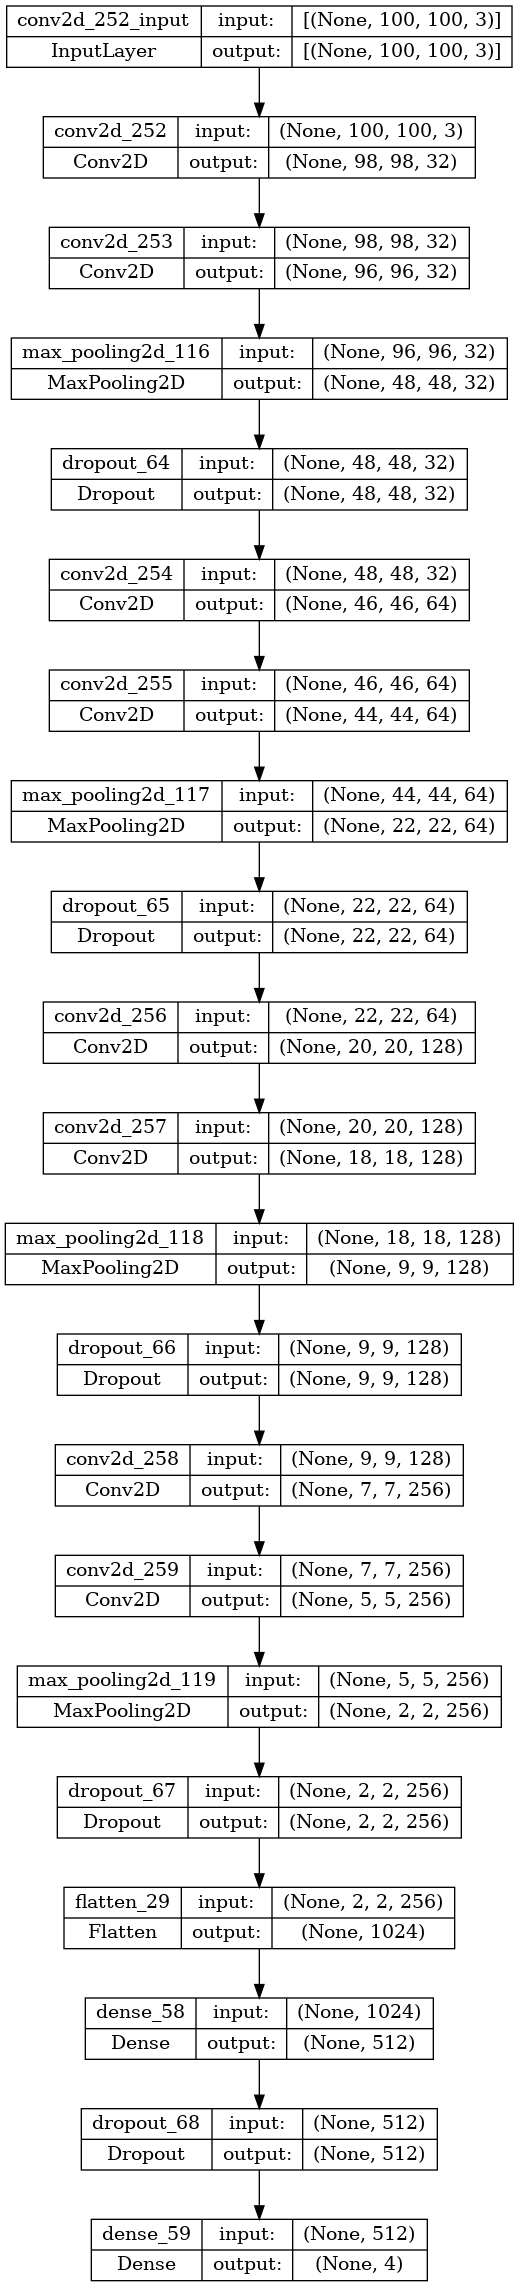

In [303]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,to_file='4class model.png')


In [304]:
from keras.metrics import Precision,Recall
import tensorflow_addons as tfa

In [305]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',Precision(name='precision'),Recall(name='Recall'),tfa.metrics.F1Score(num_classes=4)])

In [306]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath='/kaggle/working/4m-{epoch:02d}--{accuracy:4f}.hdf5'
checkpt=ModelCheckpoint(filepath=model_filepath,
                        monitor='accuracy',
                        mode='max',
                        save_best_only=True)
                

In [307]:
history = model.fit(x_train,y_train, epochs=100,batch_size=120,
                    validation_data = val_generator.flow(x_val,y_val,batch_size=120),
                   validation_steps=200,
                   verbose=1,callbacks=[checkpt])
history=history.history
model.save('/kaggle/working/4c_model.h5')

Epoch 1/100


2023-02-26 06:02:24.462056: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_29/dropout_64/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


23/23 [==============================] - 9s 236ms/step - loss: 4.3169 - accuracy: 0.2695 - precision: 0.2834 - Recall: 0.0565 - f1_score: 0.2216 - val_loss: 1.3864 - val_accuracy: 0.2372 - val_precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_f1_score: 0.0959
Epoch 2/100
23/23 [==============================] - 1s 62ms/step - loss: 1.2175 - accuracy: 0.4096 - precision: 0.6737 - Recall: 0.1627 - f1_score: 0.3402
Epoch 3/100
23/23 [==============================] - 1s 64ms/step - loss: 1.0078 - accuracy: 0.5219 - precision: 0.7139 - Recall: 0.2994 - f1_score: 0.4949
Epoch 4/100
23/23 [==============================] - 1s 61ms/step - loss: 0.7425 - accuracy: 0.6816 - precision: 0.8013 - Recall: 0.5573 - f1_score: 0.6553
Epoch 5/100
23/23 [==============================] - 1s 62ms/step - loss: 0.5582 - accuracy: 0.7699 - precision: 0.8551 - Recall: 0.6802 - f1_score: 0.7504
Epoch 6/100
23/23 [==============================] - 1s 61ms/step - loss: 0.4282 - accuracy: 0.8344 - precision: 

**CNN MODEL EVALUATION**

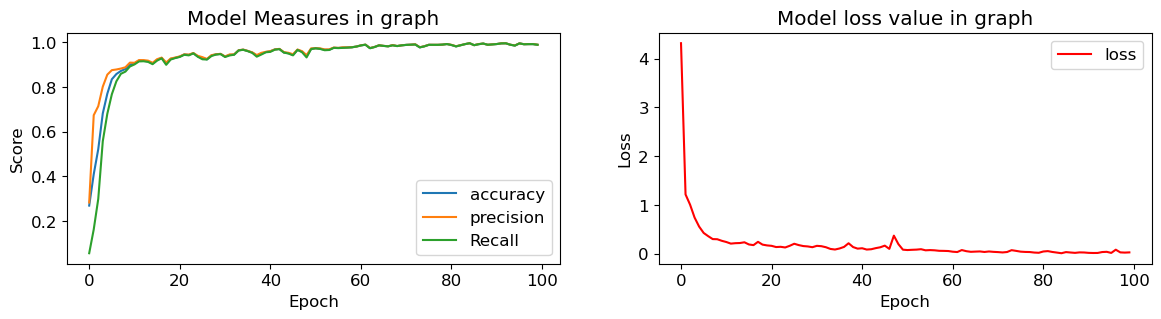

In [308]:
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(history['accuracy'])
ax1.plot(history['precision'])
ax1.plot(history["Recall"])
ax1.legend(['accuracy','precision','Recall'])
ax1.set_title('Model Measures in graph')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(history['loss'],color='red')
ax2.legend(['loss'])
ax2.set_title('Model loss value in graph')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

plt.savefig('graph.png')
plt.show()

**TEST SET**

In [332]:
best=load_model("/kaggle/working/4m-85--0.995624.hdf5")
testscore=best.evaluate(x_test,y_test)
testscore

14/14 [==============================] - 0s 7ms/step - loss: 0.2278 - accuracy: 0.9518 - precision: 0.9517 - Recall: 0.9495 - f1_score: 0.9461


[0.2278108149766922,
 0.9518348574638367,
 0.951724112033844,
 0.9495412707328796,
 array([0.90666664, 1.        , 0.88622755, 0.991453  ], dtype=float32)]

In [333]:
print('TEST DATA')
print('')
print(f"Accuracy: {round(testscore[1]*100,2)}%")
print(f"Precision: {round(testscore[2]*100,2)}%")
print(f"Recall: {round(testscore[3]*100,2)}%")
print(f"F1_score: {testscore[4]}")
print(f"Loss: {testscore[0]}")

TEST DATA

Accuracy: 95.18%
Precision: 95.17%
Recall: 94.95%
F1_score: [0.90666664 1.         0.88622755 0.991453  ]
Loss: 0.2278108149766922


In [334]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [328]:
class_names=['Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy']

In [335]:
y_pred=np.argmax(best.predict(x_test),axis=1)
y_true=np.argmax(y_test,axis=1)

14/14 [==============================] - 0s 4ms/step


In [336]:
c_test=confusion_matrix(y_true,y_pred)
c_test

array([[102,   0,   7,   0],
       [  0, 123,   0,   0],
       [ 12,   0,  74,   0],
       [  2,   0,   0, 116]])

In [337]:
print(classification_report(y_true,y_pred,target_names=class_names))

                                            precision    recall  f1-score   support

Corn___Cercospora_leaf_spot Gray_leaf_spot       0.88      0.94      0.91       109
                        Corn___Common_rust       1.00      1.00      1.00       123
               Corn___Northern_Leaf_Blight       0.91      0.86      0.89        86
                            Corn___healthy       1.00      0.98      0.99       118

                                  accuracy                           0.95       436
                                 macro avg       0.95      0.94      0.95       436
                              weighted avg       0.95      0.95      0.95       436



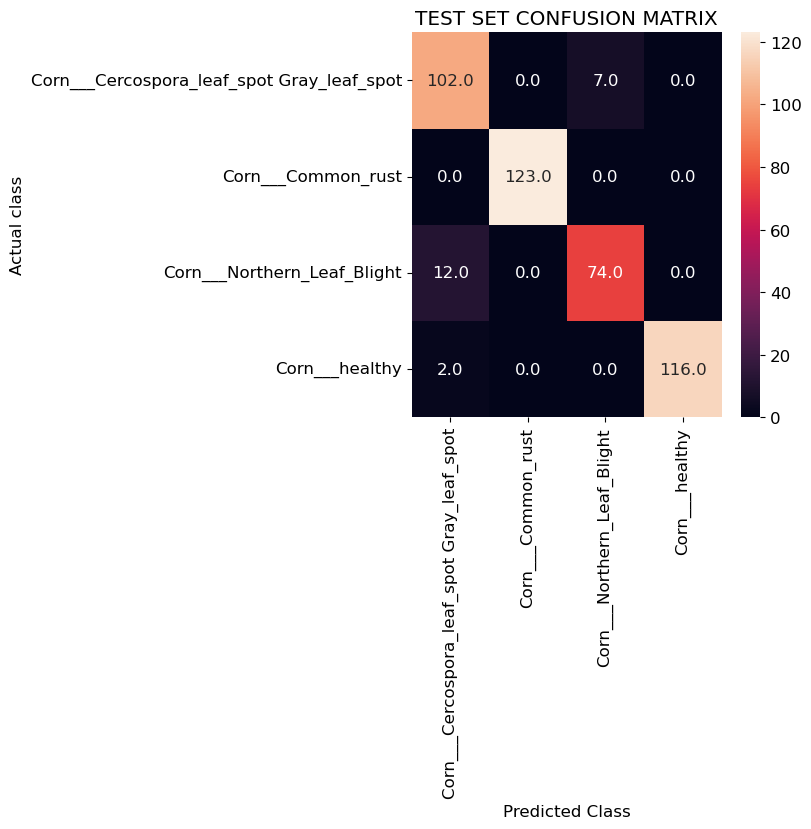

In [338]:
plt.figure(figsize=(5,5))
sns.heatmap(c_test,annot=True,xticklabels=class_names,yticklabels=class_names,fmt='.1f')
plt.title('TEST SET CONFUSION MATRIX')
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.savefig('cm test.png')
plt.show()

In [348]:
print(f"TEST SET")
print('')
for i in range(4):
    tp = c_test[i, i]
    tn = np.sum(c_test) - np.sum(c_test[i, :]) - np.sum(c_test[:, i]) + c_test[i, i]
    fp = np.sum(c_test[:, i]) - c_test[i, i]
    fn = np.sum(c_test[i, :]) - c_test[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

TEST SET

Class 0: TP=102, TN=313, FP=14, FN=7
Class 1: TP=123, TN=313, FP=0, FN=0
Class 2: TP=74, TN=343, FP=7, FN=12
Class 3: TP=116, TN=318, FP=0, FN=2


**VALIDATION SET ANALYSIS**

In [340]:
valscore=best.evaluate(x_val,y_val)
valscore

37/37 [==============================] - 0s 7ms/step - loss: 8.6482 - accuracy: 0.9422 - precision: 0.9430 - Recall: 0.9422 - f1_score: 0.9381


[8.64823055267334,
 0.942176878452301,
 0.9429787397384644,
 0.942176878452301,
 array([0.88     , 0.9969419, 0.8802946, 0.9950413], dtype=float32)]

In [341]:
print('VALIDATION DATA')
print('')
print(f"Accuracy: {round(valscore[1]*100,2)}%")
print(f"Precision: {round(valscore[2]*100,2)}%")
print(f"Recall: {round(valscore[3]*100,2)}%")
print(f"F1_score: {valscore[4]}")
print(f"Loss: {valscore[0]}")

VALIDATION DATA

Accuracy: 94.22%
Precision: 94.3%
Recall: 94.22%
F1_score: [0.88      0.9969419 0.8802946 0.9950413]
Loss: 8.64823055267334


In [342]:
yv_pred=np.argmax(best.predict(x_val),axis=1)
yv_true=np.argmax(y_val,axis=1)

37/37 [==============================] - 0s 4ms/step


In [349]:
c_val=confusion_matrix(yv_true,yv_pred)
c_val

array([[242,   0,  25,   0],
       [  0, 326,   0,   0],
       [ 38,   2, 239,   0],
       [  3,   0,   0, 301]])

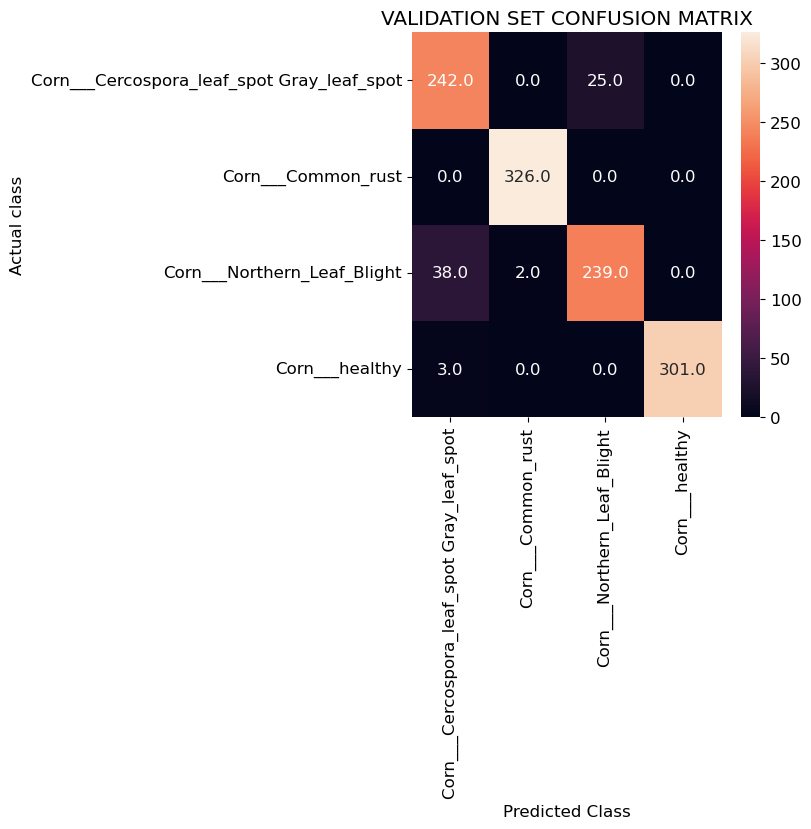

In [350]:
plt.figure(figsize=(5,5))
sns.heatmap(c_val,annot=True,xticklabels=class_names,yticklabels=class_names,fmt='.1f')
plt.title('VALIDATION SET CONFUSION MATRIX')
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.savefig('cm VAL.png')
plt.show()

In [351]:
print(classification_report(yv_true,yv_pred,target_names=class_names))

                                            precision    recall  f1-score   support

Corn___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.91      0.88       267
                        Corn___Common_rust       0.99      1.00      1.00       326
               Corn___Northern_Leaf_Blight       0.91      0.86      0.88       279
                            Corn___healthy       1.00      0.99      1.00       304

                                  accuracy                           0.94      1176
                                 macro avg       0.94      0.94      0.94      1176
                              weighted avg       0.94      0.94      0.94      1176



In [352]:
print(f"VALIDATION SET")
print('')
for i in range(4):
    tp = c_val[i, i]
    tn = np.sum(c_val) - np.sum(c_val[i, :]) - np.sum(c_val[:, i]) + c_val[i, i]
    fp = np.sum(c_val[:, i]) - c_val[i, i]
    fn = np.sum(c_val[i, :]) - c_val[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

VALIDATION SET

Class 0: TP=242, TN=868, FP=41, FN=25
Class 1: TP=326, TN=848, FP=2, FN=0
Class 2: TP=239, TN=872, FP=25, FN=40
Class 3: TP=301, TN=872, FP=0, FN=3


**IMAGE PREDICTIONS WITH PERCENTAGES**

1/1 [==============================] - 0s 19ms/step


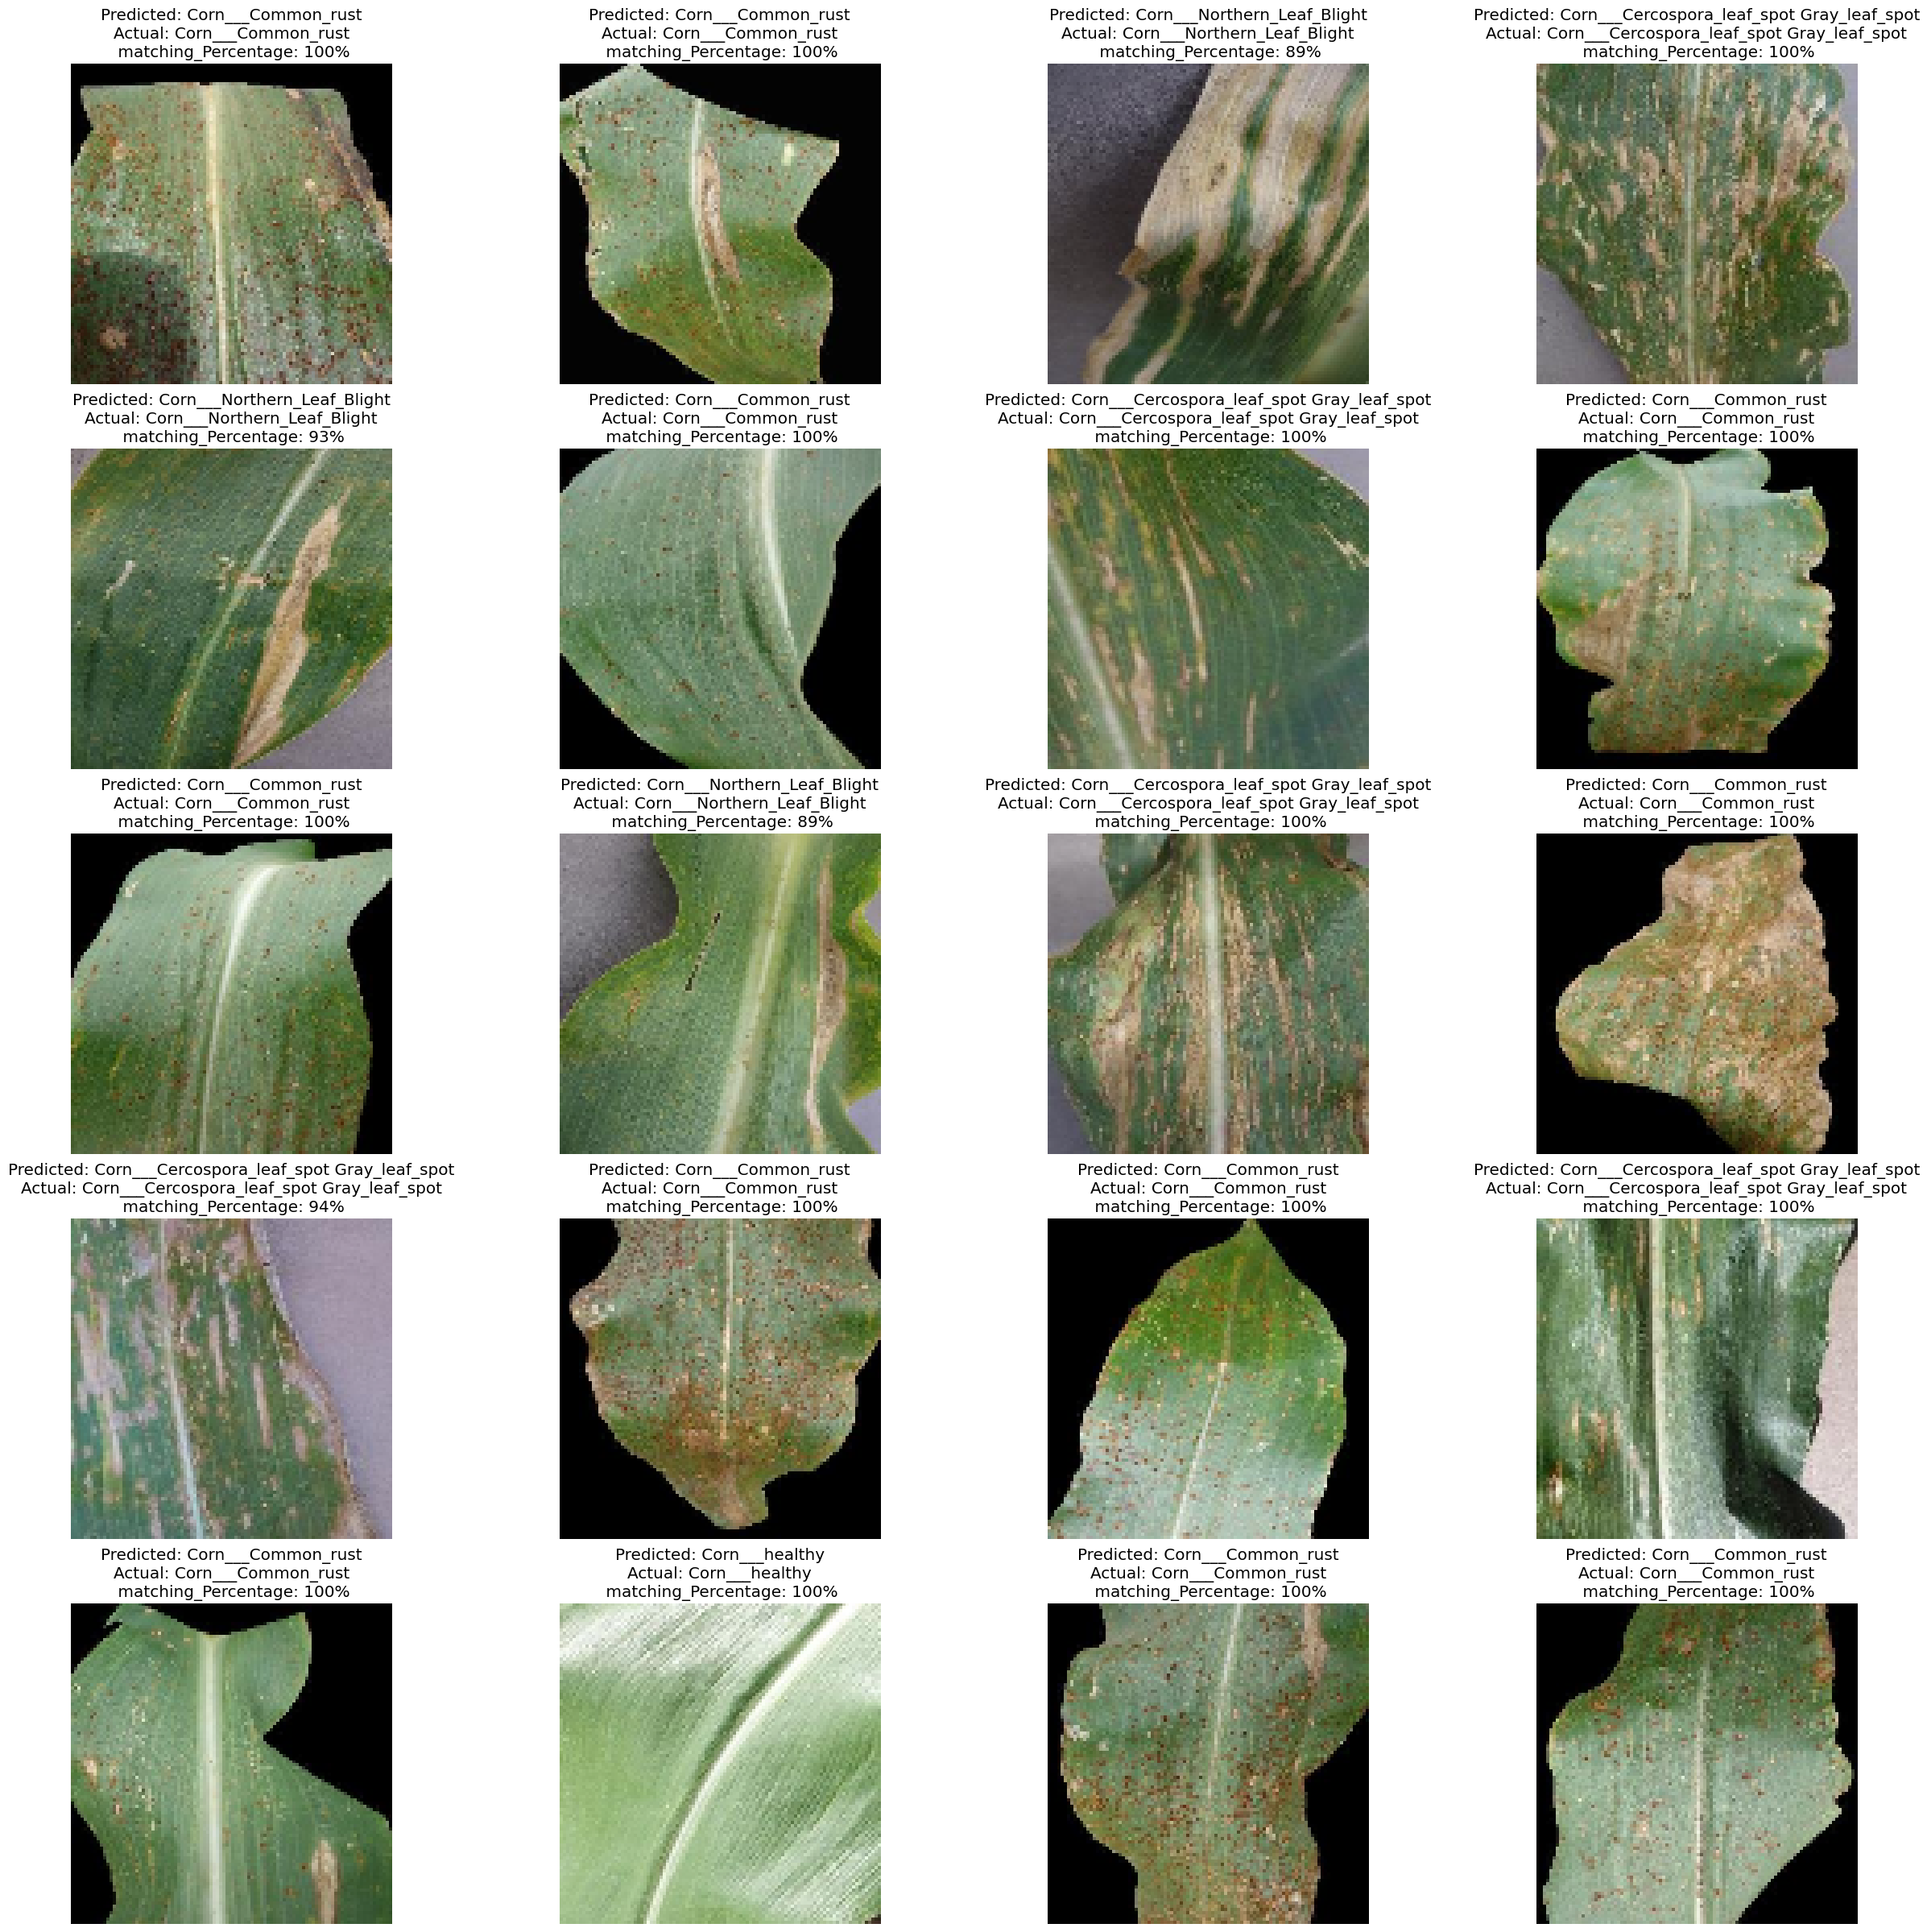

In [353]:

plt.figure(figsize=(30, 30))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for i in range(20):
    idx = np.random.randint(len(y))
    img, true_class = x[idx], categories[y[idx].squeeze()]

    # predict class probabilities for the current image
    probs = model.predict(img[None, :, :, :])[0]
    pred_class = categories[np.argmax(probs)]
    max_prob = np.max(probs)*100
    plt.rcParams.update({'font.size':12})
    plt.subplot(5, 4, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Predicted: {pred_class}\nActual: {true_class}\n matching_Percentage: {round(max_prob)}%")
    plt.axis("off")
plt.show()